In [25]:
#Basic Libraries
import pandas as pd
import numpy as np
import datetime as dt


#Visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")


# ML Matrix + Performance params
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

#Fixing Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.pipeline import Pipeline


#Load the ML Algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.cluster import DBSCAN

# Geospatial
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
# import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
from itertools import cycle

In [26]:
bbox_coordinates =  {'0' : (144.8,-38.5,145.8,-37.5),
                     '1' : (150.7,-33.5,151.7,-32.5),
                     '2' : (152.6,-29.0,153.6,-28.0),
                     '3' : (145.0,-17.7,146.0,-16.7),
                     '4' : (115.7,-32.5,116.7,-31.5)}

In [27]:
def filter_bbox(frogs, bbox_clusters):
    frogs_fnl = pd.DataFrame()
    for y in bbox_clusters:
        frogs_temp = frogs[lambda x: 
            (x.decimalLongitude >= bbox_clusters[y][0]) &
            (x.decimalLatitude >= bbox_clusters[y][1]) &
            (x.decimalLongitude <= bbox_clusters[y][2]) &
            (x.decimalLatitude <= bbox_clusters[y][3])    ]
        frogs_temp.cluster = y
        frogs_fnl = pd.concat([frogs_fnl,frogs_temp])
    return frogs_fnl

def get_frogs(file, year_range=None, bbox_clusters=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    
    frogs['cluster'] = np.nan
    
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox_clusters is not None:
        frogs = filter_bbox(frogs, bbox_clusters)
    return frogs

In [28]:
# Load in data
all_frog_data = get_frogs('occurrence.txt', year_range=(2017, 2018), bbox_clusters=bbox_coordinates)
all_frog_data

C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (2,9,35,39,42,46,47,48,54,56,57,58,59,60,62,64,65,66,68,69,70,71,74,75,76,77,78,79,82,84,85,86,87,88,89,90,92,96,97,99,101,103,109,110,111,114,115,116,117,118,119,120,121,122,123,126,127,128,129,130,135,136,142,143,145,147,148,149,150,151,161,165,170,172,173,174,175,176,177,178,179,180,181,185,189,190,191,192,193,195,207,210,212,215,217,225,226,242,246,254,255) have mixed types.Specify dtype option on import or set low_memory=False.
  
C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,cluster
2780,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0
4737,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0
4836,3463456685,2018-12-13 00:00:00,Australia,Australia,Victoria,-37.807617,145.263677,Crinia Signifera,0
4837,3463456686,2017-12-03 00:00:00,Australia,Australia,Victoria,-37.787189,145.007098,Crinia Signifera,0
4964,3463457165,2018-05-18 00:00:00,Australia,Australia,Victoria,-37.861645,145.523670,Crinia Signifera,0
...,...,...,...,...,...,...,...,...,...
95794,1935325272,2018-08-03 16:00:00,Australia,Australia,Western Australia,-31.969132,116.129728,Crinia Glauerti,4
95809,1640023933,2017-09-09 16:00:00,Australia,Australia,Western Australia,-31.933553,115.909463,Crinia Glauerti,4
149899,3381434234,2017-11-18 00:00:00,Australia,Australia,Western Australia,-32.242003,115.834441,Crinia Signifera,4
151331,3381443465,2017-11-17 00:00:00,Australia,Australia,Western Australia,-31.775465,115.742627,Crinia Signifera,4


In [29]:
all_frog_data.cluster.value_counts()

1    2877
4    1750
0    1536
2     928
3     234
Name: cluster, dtype: int64

In [30]:
all_frog_data.groupby(['cluster','species']).count()['gbifID']

cluster  species                  
0        Crinia Signifera             1483
         Litoria Fallax                 53
1        Crinia Signifera             1123
         Litoria Fallax               1754
2        Crinia Signifera              190
         Litoria Fallax                738
3        Austrochaperina Pluvialis      23
         Litoria Fallax                211
4        Crinia Glauerti              1747
         Crinia Signifera                3
Name: gbifID, dtype: int64

<AxesSubplot:xlabel='decimalLatitude', ylabel='decimalLongitude'>

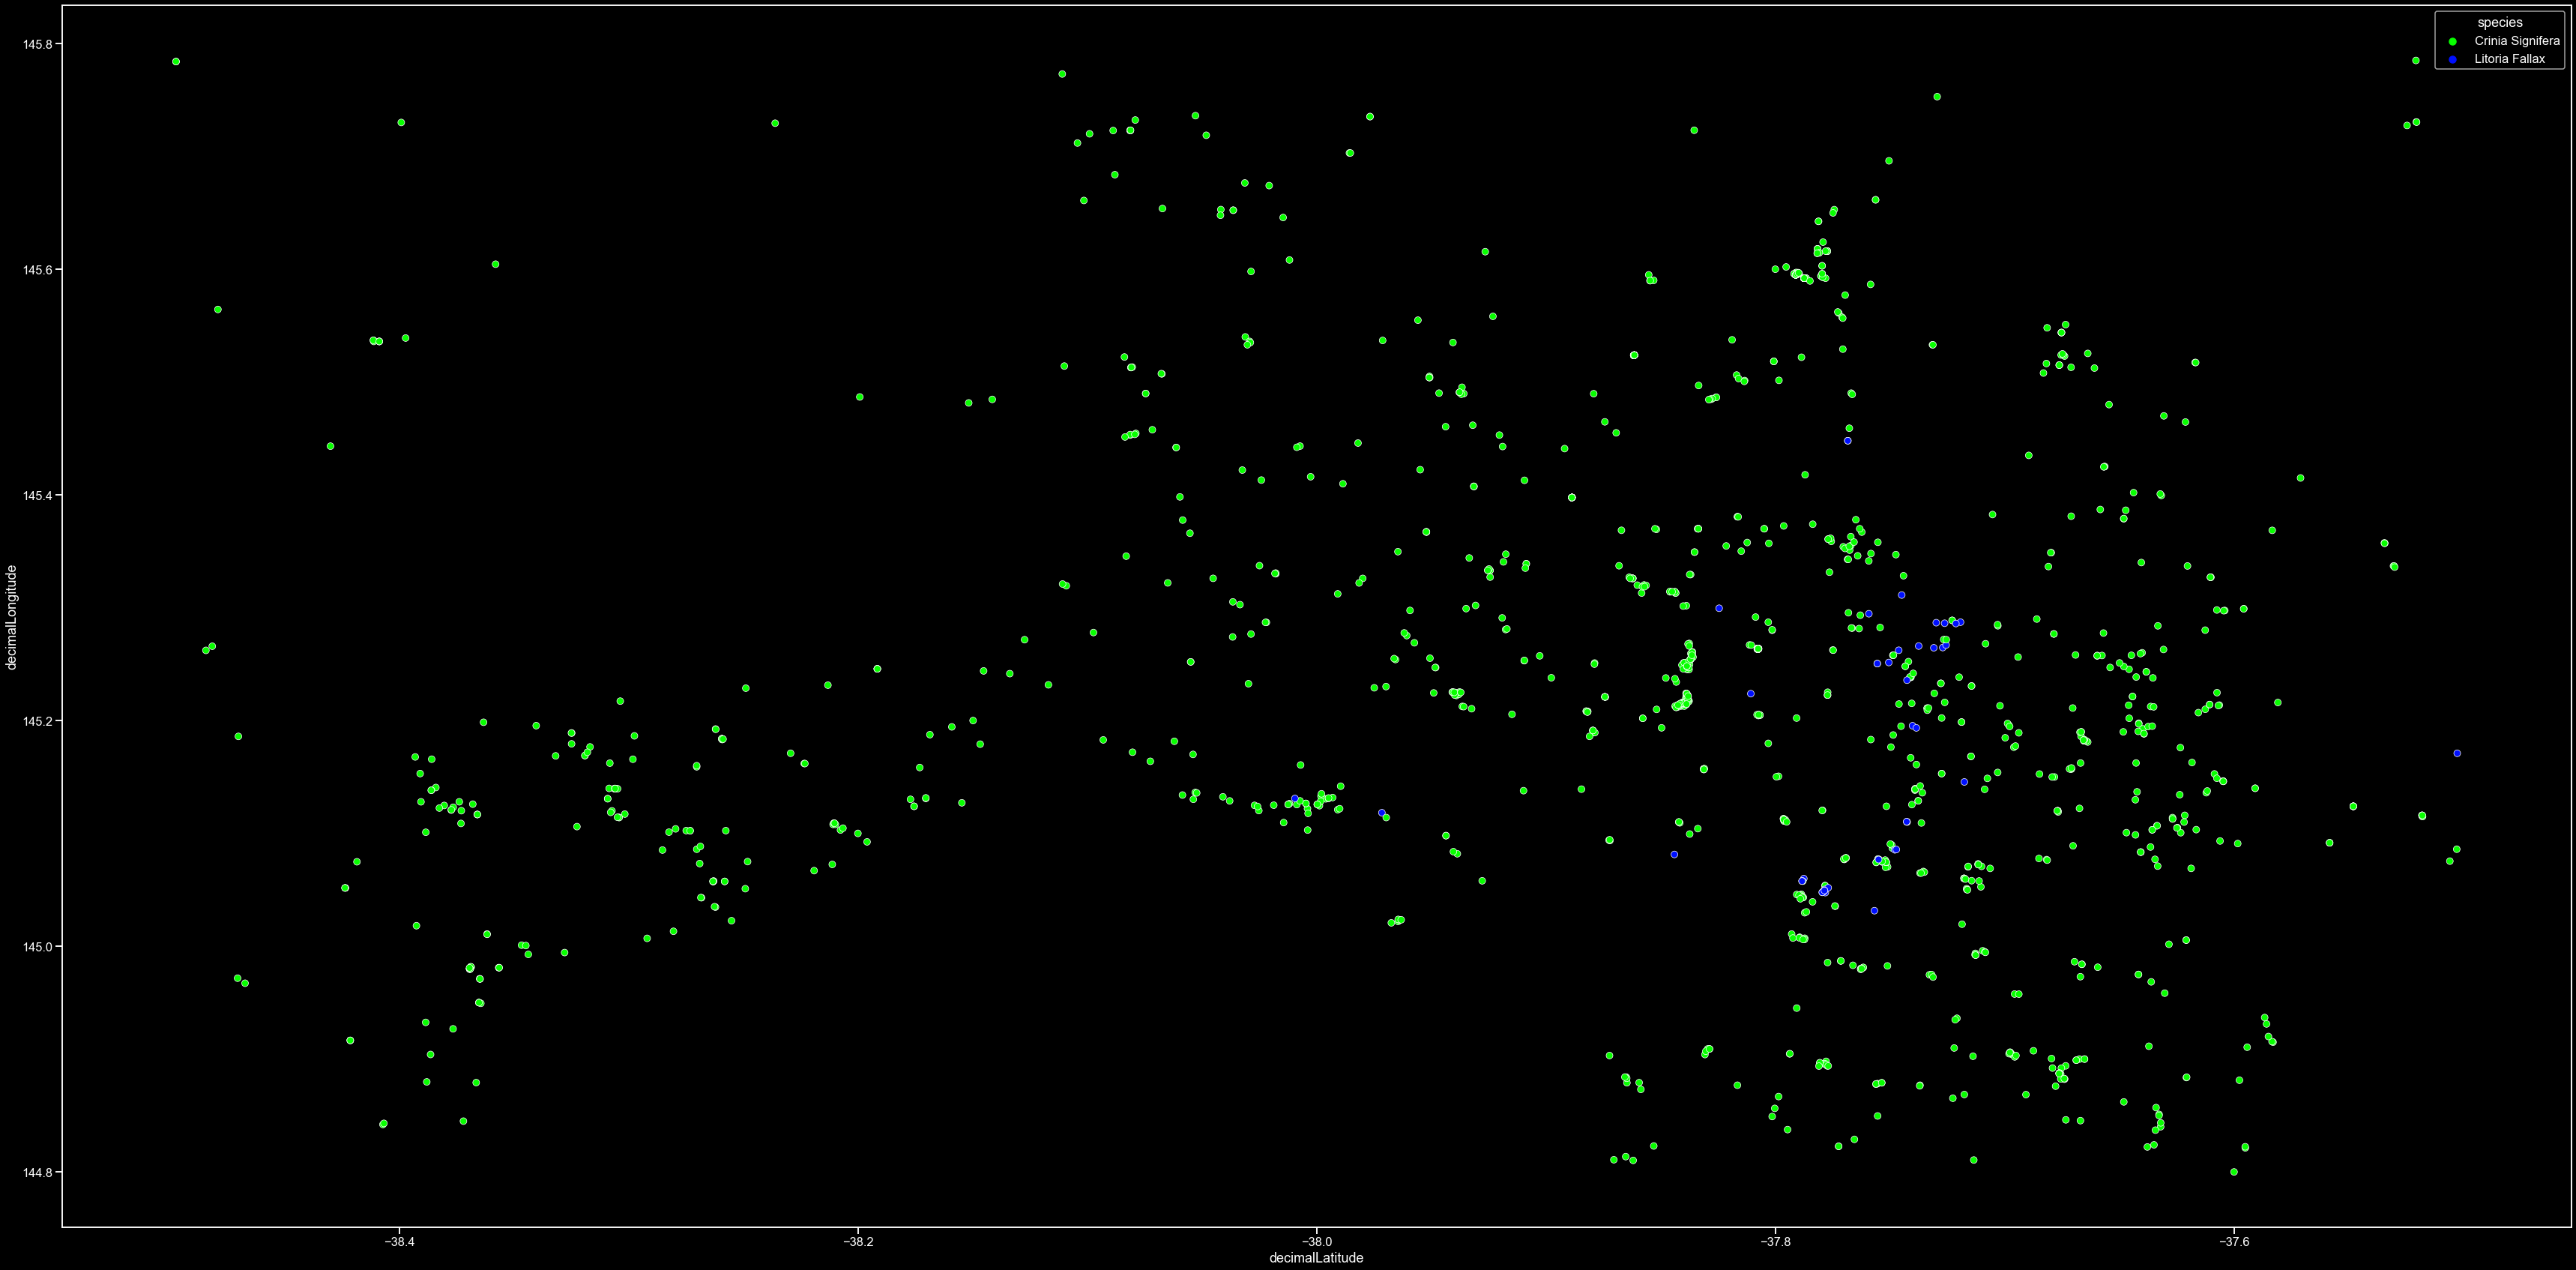

In [31]:
fig, ax = plt.subplots(figsize = (60, 30))
temp = all_frog_data.loc[all_frog_data.cluster == '0']
sns.scatterplot(x=temp.decimalLatitude, 
                y = temp.decimalLongitude,
                hue=temp.species, palette='hsv' )

In [32]:
all_frog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7325 entries, 2780 to 152823
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            7325 non-null   int64         
 1   eventDate         7325 non-null   datetime64[ns]
 2   country           7325 non-null   object        
 3   continent         7325 non-null   object        
 4   stateProvince     7325 non-null   object        
 5   decimalLatitude   7325 non-null   float64       
 6   decimalLongitude  7325 non-null   float64       
 7   species           7325 non-null   object        
 8   cluster           7325 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 572.3+ KB


In [33]:
all_frog_data.species.value_counts() #Class imbalance exits

Crinia Signifera             2799
Litoria Fallax               2756
Crinia Glauerti              1747
Austrochaperina Pluvialis      23
Name: species, dtype: int64

In [34]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .reset_index(drop=True).assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0),
        key= lambda x: x.index
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,cluster,occurrenceStatus,key
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0,0
1,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,0,1
2,3463456685,2018-12-13 00:00:00,Australia,Australia,Victoria,-37.807617,145.263677,Crinia Signifera,0,0,2
3,3463456686,2017-12-03 00:00:00,Australia,Australia,Victoria,-37.787189,145.007098,Crinia Signifera,0,0,3
4,3463457165,2018-05-18 00:00:00,Australia,Australia,Victoria,-37.861645,145.523670,Crinia Signifera,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
7320,1935325272,2018-08-03 16:00:00,Australia,Australia,Western Australia,-31.969132,116.129728,Crinia Glauerti,4,0,7320
7321,1640023933,2017-09-09 16:00:00,Australia,Australia,Western Australia,-31.933553,115.909463,Crinia Glauerti,4,0,7321
7322,3381434234,2017-11-18 00:00:00,Australia,Australia,Western Australia,-32.242003,115.834441,Crinia Signifera,4,0,7322
7323,3381443465,2017-11-17 00:00:00,Australia,Australia,Western Australia,-31.775465,115.742627,Crinia Signifera,4,0,7323


In [35]:
all_frog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7325 entries, 0 to 7324
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            7325 non-null   int64         
 1   eventDate         7325 non-null   datetime64[ns]
 2   country           7325 non-null   object        
 3   continent         7325 non-null   object        
 4   stateProvince     7325 non-null   object        
 5   decimalLatitude   7325 non-null   float64       
 6   decimalLongitude  7325 non-null   float64       
 7   species           7325 non-null   object        
 8   cluster           7325 non-null   object        
 9   occurrenceStatus  7325 non-null   int32         
 10  key               7325 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(5)
memory usage: 601.0+ KB


In [36]:
len(all_frog_data.key.unique())

7325

In [37]:
all_frog_data.occurrenceStatus.value_counts()

0    4569
1    2756
Name: occurrenceStatus, dtype: int64

In [39]:
all_frog_data["Month"] = all_frog_data.eventDate.dt.month

In [40]:
all_frog_data.groupby('Month').count()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,cluster,occurrenceStatus,key
Month,,,,,,,,,,,
1,158,158,158,158,158,158,158,158,158,158,158
2,143,143,143,143,143,143,143,143,143,143,143
3,206,206,206,206,206,206,206,206,206,206,206
4,146,146,146,146,146,146,146,146,146,146,146
5,156,156,156,156,156,156,156,156,156,156,156
6,315,315,315,315,315,315,315,315,315,315,315
7,461,461,461,461,461,461,461,461,461,461,461
8,567,567,567,567,567,567,567,567,567,567,567
9,917,917,917,917,917,917,917,917,917,917,917


In [41]:
frog_trend = all_frog_data.groupby('Month').count()['occurrenceStatus'].copy()

In [42]:
all_frog_data.loc[all_frog_data.occurrenceStatus == 1].groupby('Month').count()['occurrenceStatus']

Month
1     125
2      84
3      79
4      29
5      10
6       8
7      12
8      25
9     135
10    436
11    935
12    878
Name: occurrenceStatus, dtype: int64

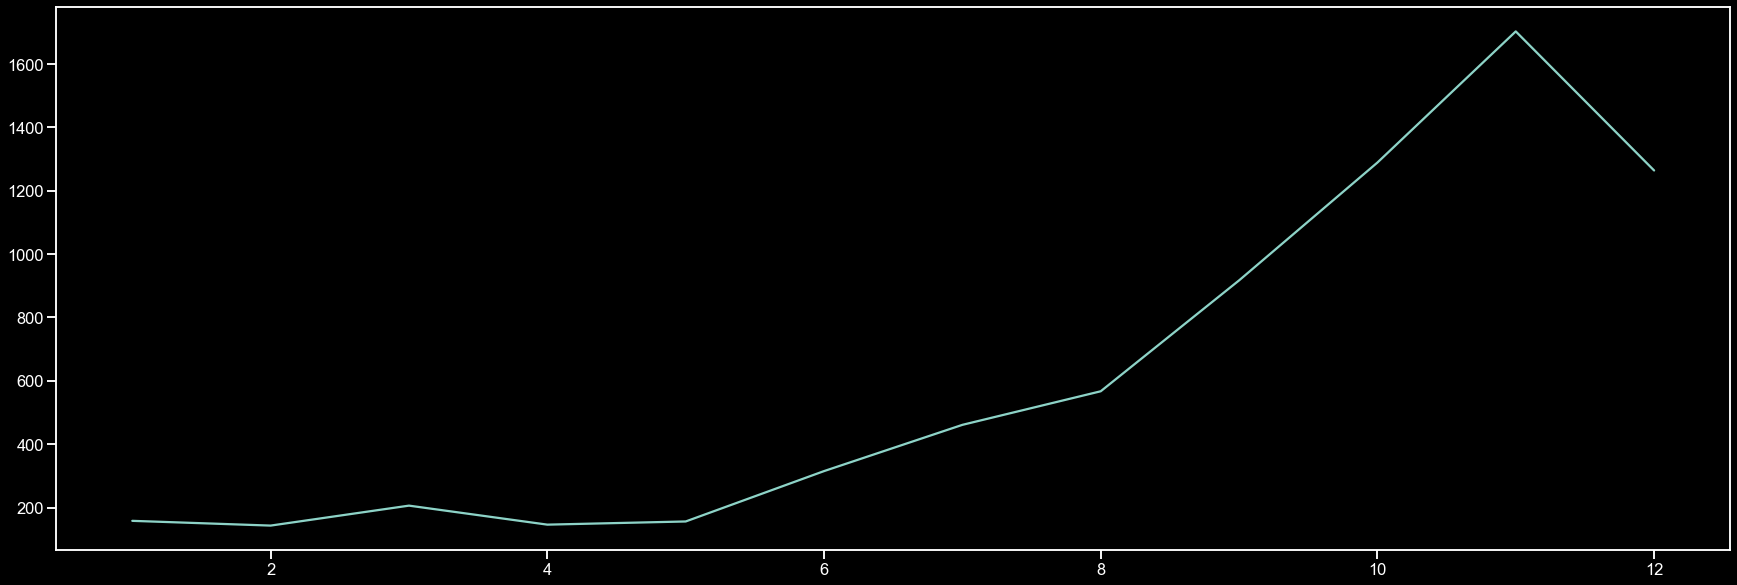

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.plot(frog_trend)

In [19]:
for x in bbox_coordinates.values():
    print(x)

(144.8, -38.5, 145.8, -37.5)
(150.7, -33.5, 151.7, -32.5)
(152.6, -29.0, 153.6, -28.0)
(145.0, -17.7, 146.0, -16.7)
(115.7, -32.5, 116.7, -31.5)


In [20]:
all_frog_data.columns


Index(['gbifID', 'eventDate', 'country', 'continent', 'stateProvince',
       'decimalLatitude', 'decimalLongitude', 'species', 'cluster',
       'occurrenceStatus', 'key', 'Month'],
      dtype='object')

In [21]:
all_frog_data.groupby(['cluster','occurrenceStatus']).count()['key']


cluster  occurrenceStatus
0        0                   3299
         1                     84
1        0                   4715
         1                   4771
2        0                    352
         1                    956
3        0                    104
         1                    803
4        0                   4963
Name: key, dtype: int64

In [79]:
all_frog_data.loc[all_frog_data.cluster.isin(['0','1','2','3'])][[ 'decimalLatitude', 'decimalLongitude','cluster']]

,decimalLatitude,decimalLongitude,cluster
0,-38.045122,145.326047,0
1,-38.030947,145.432053,0
2,-38.088716,145.722909,0
3,-37.807553,145.263607,0
4,-37.991842,145.118825,0
...,...,...,...
21238,-17.300000,145.500000,3
21239,-17.481442,145.509045,3
21240,-17.022503,145.737752,3
21241,-16.798822,145.547842,3


In [80]:
all_frog_data[['decimalLatitude', 'decimalLongitude']]

,decimalLatitude,decimalLongitude
0,-38.045122,145.326047
1,-38.030947,145.432053
2,-38.088716,145.722909
3,-37.807553,145.263607
4,-37.991842,145.118825
...,...,...
27952,-31.933553,115.909463
27953,-32.014768,115.895289
27954,-32.242003,115.834441
27955,-31.775465,115.742627


In [40]:
# # define pipeline
# over = SMOTE(sampling_strategy=0.9)
# under = RandomUnderSampler(sampling_strategy=0.8)
# steps = [('u', under), ('o',over)]
# pipeline = Pipeline(steps=steps)
# # transform the dataset
# X, y = pipeline.fit_resample(X, y)

# temp_df = pd.concat([X,y],axis=1)
# print(y.value_counts())

source  = all_frog_data[['decimalLatitude', 'decimalLongitude','cluster','key']]
target = all_frog_data[['occurrenceStatus']]

# summarize class distribution
print(target.value_counts())

# define pipeline
#Oversampling using smote - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# smt = SMOTETomek(sampling_strategy = 'auto')
# source_res, target_res = smt.fit_resample(source, target)

# define pipeline
over = SMOTE(sampling_strategy=0.9)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('u', under), ('o',over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
source_res, target_res = pipeline.fit_resample(source, target)


# summarize class distribution
print(target_res.value_counts())

occurrenceStatus
0                   18387
1                    9570
dtype: int64
occurrenceStatus
0                   11962
1                   10765
dtype: int64


In [42]:
fnl_data = pd.concat([source_res,target_res],axis=1)
fnl_data.cluster = fnl_data.cluster.astype('int')
fnl_data.groupby(['cluster','occurrenceStatus']).count()['key']


cluster  occurrenceStatus
0        0                   3284
         1                    158
1        0                   3877
         1                   7496
2        0                    349
         1                   1978
3        0                     83
         1                   1133
4        0                   4369
Name: key, dtype: int64

<AxesSubplot:xlabel='decimalLongitude', ylabel='decimalLatitude'>

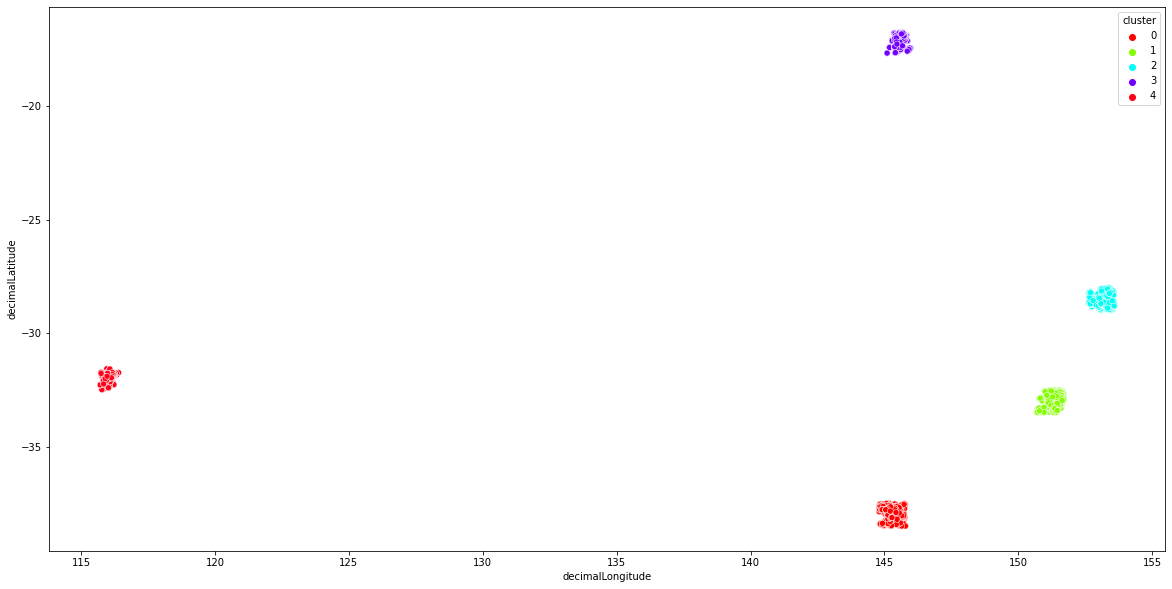

In [34]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(x = fnl_data.decimalLongitude,  
                y = fnl_data.decimalLatitude, 
                hue=fnl_data.cluster, palette='hsv')

cluster  occurrenceStatus
0        0                    5014
         1                     259
1        0                    5881
         1                   12734
2        0                     530
         1                    3328
3        0                     124
         1                    1942
4        0                    6714
Name: decimalLatitude, dtype: int64

D:(

all_frog_data.columns

In [45]:
all_frog_data = all_frog_data[['decimalLatitude', 'decimalLongitude', 'cluster',
       'occurrenceStatus', 'key']]

In [46]:
all_frog_data = (
    all_frog_data.reset_index(drop=True).assign(key= lambda x: x.index))
all_frog_data.cluster = all_frog_data.cluster.astype(int)
all_frog_data

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key
0,-38.045122,145.326047,0,0,0
1,-38.088716,145.722909,0,0,1
2,-37.807617,145.263677,0,0,2
3,-37.787189,145.007098,0,0,3
4,-37.861645,145.523670,0,0,4
...,...,...,...,...,...
7320,-31.969132,116.129728,4,0,7320
7321,-31.933553,115.909463,4,0,7321
7322,-32.242003,115.834441,4,0,7322
7323,-31.775465,115.742627,4,0,7323


In [47]:
for bbox_num in range(len(bbox_coordinates)):
    print(list(bbox_coordinates.values())[bbox_num])

(144.8, -38.5, 145.8, -37.5)
(150.7, -33.5, 151.7, -32.5)
(152.6, -29.0, 153.6, -28.0)
(145.0, -17.7, 146.0, -16.7)
(115.7, -32.5, 116.7, -31.5)


In [48]:
for bbox in list(bbox_coordinates.values()):
                 print(bbox)

(144.8, -38.5, 145.8, -37.5)
(150.7, -33.5, 151.7, -32.5)
(152.6, -29.0, 153.6, -28.0)
(145.0, -17.7, 146.0, -16.7)
(115.7, -32.5, 116.7, -31.5)


In [49]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [50]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frogs.decimalLongitude, dims="key", coords={"key": frogs.key}), 
                y=xr.DataArray(frogs.decimalLatitude, dims="key", coords={"key": frogs.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot_table(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

In [51]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2019-09-01','2019-11-30')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil',
       'aet', 
        'def', 
        'pet',
        'vap', 
        'vpd', 
        'pdsi', 
        'srad','q','ws']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 
          'aet_mean', 
          'def_mean', 
          'pet_mean',
          'vap_mean', 
          'vpd_mean', 
          'pdsi_mean', 
          'srad_mean',
         'q_mean',
         'ws_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)


model_data = pd.DataFrame()

for bbox_num in range(len(bbox_coordinates)):
    
    bbox = list(bbox_coordinates.values())[bbox_num]
    
    frog_data_temp = all_frog_data.loc[all_frog_data.cluster == bbox_num]
    
    weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
    display(weather_data.band.values)
    
    model_temp = join_frogs(frog_data_temp, weather_data)
    
    model_data = pd.concat([model_data,model_temp])

C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\xarray\backends\plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Loading data
Calculating mean


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean', 'q_mean', 'ws_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean', 'q_mean', 'ws_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean', 'q_mean', 'ws_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean', 'q_mean', 'ws_mean'], dtype='<U9')

Loading data
Calculating mean


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\HM358WJ\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'pet_mean', 'vap_mean', 'vpd_mean', 'pdsi_mean',
       'srad_mean', 'q_mean', 'ws_mean'], dtype='<U9')

In [52]:
model_data.head()

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,-38.045122,145.326047,0,0,0,92.666667,14.666667,-2.400000,107.333333,77.666667,4.000000,167.333333,214.000000,18.433334,8.600001,1.063333,0.566667,5.866667
1,-38.088716,145.722909,0,0,1,96.666667,7.000000,-2.633333,103.666667,96.666667,5.000000,226.000000,214.000000,18.433334,7.933334,1.063333,0.546667,5.433333
2,-37.807617,145.263677,0,0,2,97.000000,12.000000,-2.000000,109.000000,89.666667,10.666667,140.333333,213.333333,18.666669,8.233335,1.020000,0.613333,5.200000
3,-37.787189,145.007098,0,0,3,76.000000,44.000000,-2.666667,119.666667,65.333333,3.333333,42.000000,215.333333,19.566666,9.199999,1.046667,0.690000,5.900000
4,-37.861645,145.523670,0,0,4,97.000000,4.333333,-1.966666,101.000000,110.333333,19.333333,218.000000,213.666667,18.000000,7.333336,1.020000,0.536667,4.900000


In [53]:
model_data.tail()

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
1745,-31.969132,116.129728,4,0,7320,77.333333,62.666667,-3.699999,140.000000,49.333333,2.666667,78.666667,288.333333,21.733335,10.066668,1.086667,0.860000,3.833333
1746,-31.933553,115.909463,4,0,7321,68.666667,81.666667,-4.300000,150.000000,35.000000,1.666667,72.666667,287.333333,23.300001,12.600001,1.260000,0.926667,4.500000
1747,-32.242003,115.834441,4,0,7322,74.000000,73.666667,-4.233333,147.333333,39.666667,2.000000,79.333333,287.333333,22.866666,12.300001,1.273333,0.863333,4.866667
1748,-31.775465,115.742627,4,0,7323,56.000000,95.333333,-4.766666,150.666667,29.000000,1.666667,51.000000,289.000000,23.066668,12.566666,1.316667,0.846667,5.700000
1749,-31.899749,115.966779,4,0,7324,70.000000,80.333333,-3.833333,150.333333,34.666667,1.666667,73.000000,289.333333,23.600001,12.000000,1.230000,0.956667,4.200000


In [54]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7320 entries, 0 to 1749
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   decimalLatitude   7320 non-null   float64
 1   decimalLongitude  7320 non-null   float64
 2   cluster           7320 non-null   int32  
 3   occurrenceStatus  7320 non-null   int32  
 4   key               7320 non-null   int64  
 5   aet_mean          7320 non-null   float64
 6   def_mean          7320 non-null   float64
 7   pdsi_mean         7320 non-null   float64
 8   pet_mean          7320 non-null   float64
 9   ppt_mean          7320 non-null   float64
 10  q_mean            7320 non-null   float64
 11  soil_mean         7320 non-null   float64
 12  srad_mean         7320 non-null   float64
 13  tmax_mean         7320 non-null   float64
 14  tmin_mean         7320 non-null   float64
 15  vap_mean          7320 non-null   float64
 16  vpd_mean          7320 non-null   float64


In [55]:
model_data.describe()

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
count,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000
mean,-32.743698,141.700651,1.698087,0.376503,3662.698224,68.250046,64.596038,-4.205665,132.812705,51.788798,3.698907,71.322905,260.569672,22.609041,11.771017,1.264774,0.840107,4.076248
std,3.999713,14.703812,1.459138,0.484542,2115.153252,19.244317,29.868858,1.765410,15.746548,21.799754,4.607932,49.363690,25.630713,2.476012,2.285548,0.194522,0.161370,1.029482
min,-38.497300,115.707234,0.000000,0.000000,0.000000,16.000000,0.000000,-8.566666,90.666667,3.333333,0.000000,3.333333,211.666667,15.333336,4.733334,0.873333,0.443333,2.366667
25%,-33.425674,144.899000,1.000000,0.000000,1829.750000,55.666667,51.333333,-5.466667,128.000000,35.000000,1.666667,37.333333,262.333333,22.566668,10.633336,1.110000,0.783333,3.100000
50%,-32.968817,151.161481,1.000000,0.000000,3663.500000,68.666667,72.666667,-4.300000,133.000000,49.000000,2.333333,66.666667,264.000000,23.100001,12.366669,1.260000,0.856667,4.066667
75%,-31.935400,151.520196,3.000000,1.000000,5494.250000,83.666667,81.666667,-3.699999,146.000000,60.666667,3.000000,85.666667,285.666667,23.533335,12.733335,1.340000,0.926667,4.633333
max,-16.739402,153.598000,4.000000,1.000000,7324.000000,106.333333,137.666667,3.533333,173.666667,143.333333,49.666667,296.666667,297.333333,29.133336,20.100004,2.133333,1.396667,7.333333


In [57]:
model_data

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,-38.045122,145.326047,0,0,0,92.666667,14.666667,-2.400000,107.333333,77.666667,4.000000,167.333333,214.000000,18.433334,8.600001,1.063333,0.566667,5.866667
1,-38.088716,145.722909,0,0,1,96.666667,7.000000,-2.633333,103.666667,96.666667,5.000000,226.000000,214.000000,18.433334,7.933334,1.063333,0.546667,5.433333
2,-37.807617,145.263677,0,0,2,97.000000,12.000000,-2.000000,109.000000,89.666667,10.666667,140.333333,213.333333,18.666669,8.233335,1.020000,0.613333,5.200000
3,-37.787189,145.007098,0,0,3,76.000000,44.000000,-2.666667,119.666667,65.333333,3.333333,42.000000,215.333333,19.566666,9.199999,1.046667,0.690000,5.900000
4,-37.861645,145.523670,0,0,4,97.000000,4.333333,-1.966666,101.000000,110.333333,19.333333,218.000000,213.666667,18.000000,7.333336,1.020000,0.536667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,-31.969132,116.129728,4,0,7320,77.333333,62.666667,-3.699999,140.000000,49.333333,2.666667,78.666667,288.333333,21.733335,10.066668,1.086667,0.860000,3.833333
1746,-31.933553,115.909463,4,0,7321,68.666667,81.666667,-4.300000,150.000000,35.000000,1.666667,72.666667,287.333333,23.300001,12.600001,1.260000,0.926667,4.500000
1747,-32.242003,115.834441,4,0,7322,74.000000,73.666667,-4.233333,147.333333,39.666667,2.000000,79.333333,287.333333,22.866666,12.300001,1.273333,0.863333,4.866667
1748,-31.775465,115.742627,4,0,7323,56.000000,95.333333,-4.766666,150.666667,29.000000,1.666667,51.000000,289.000000,23.066668,12.566666,1.316667,0.846667,5.700000


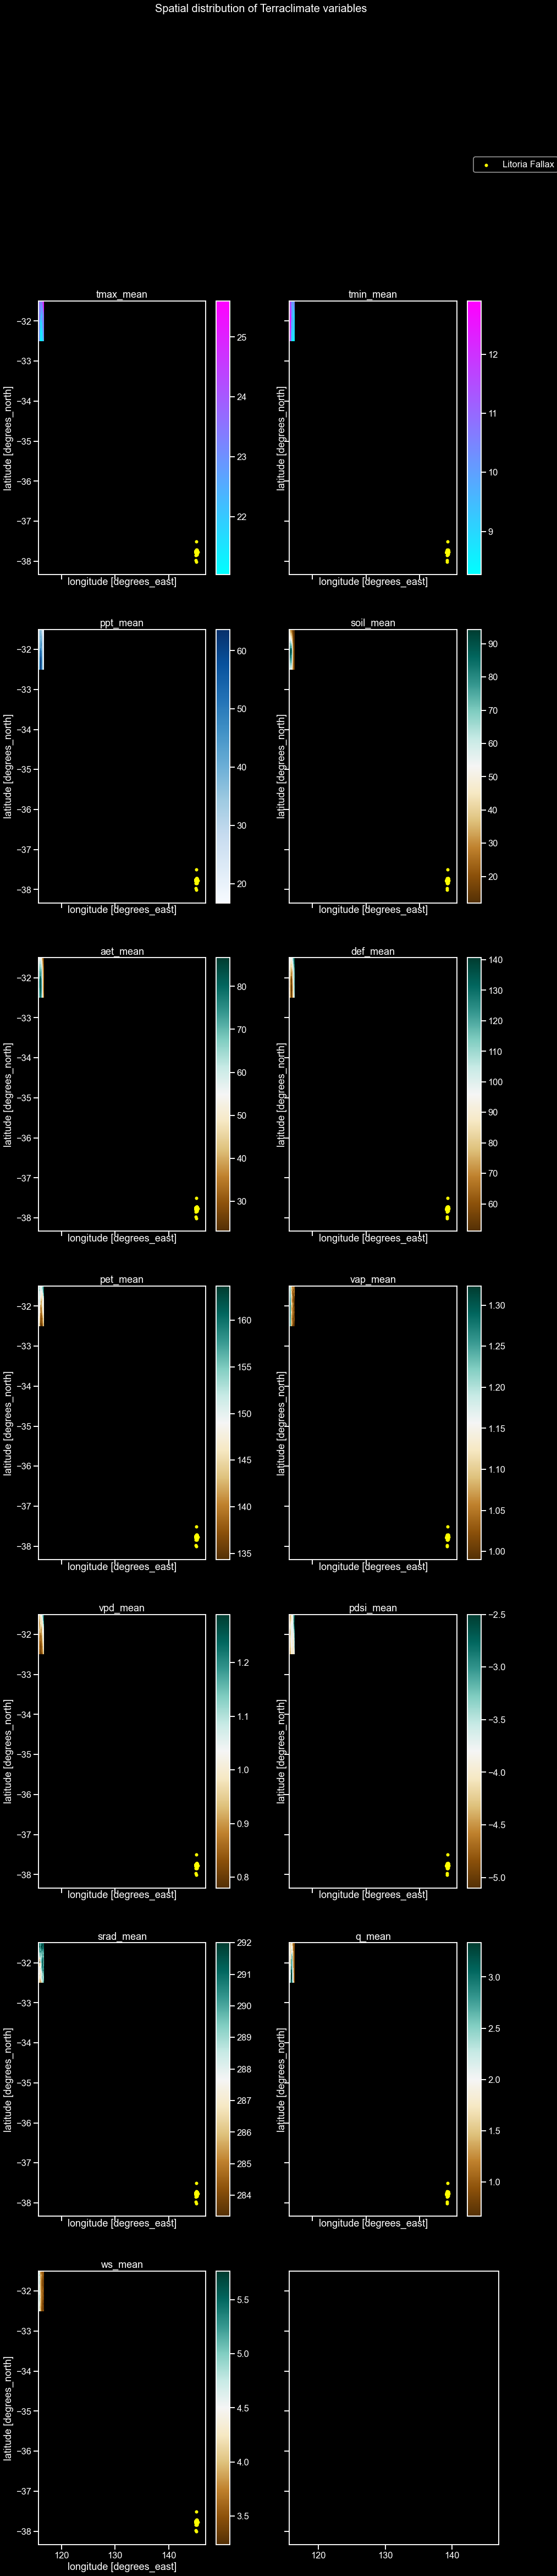

In [61]:
nrow = 7
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(15, 75), sharex=True, sharey=True)

bands = weather_data.band.values
filt = (model_data.occurrenceStatus == 1) & (model_data.cluster == 0)
cmaps = ["cool", "cool", "Blues", "BrBG", "BrBG" , "BrBG", "BrBG", "BrBG", "BrBG", "BrBG", "BrBG", "BrBG", "BrBG", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(model_data[filt].decimalLongitude, model_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

In [ ]:
D:(

In [35]:
model_data.to_csv('terraclimate_5cluster_2019_Sep_2019_Nov.csv')

In [36]:
model_data.columns

Index(['decimalLatitude', 'decimalLongitude', 'cluster', 'occurrenceStatus',
       'key', 'aet_mean', 'def_mean', 'pdsi_mean', 'pet_mean', 'ppt_mean',
       'q_mean', 'soil_mean', 'srad_mean', 'tmax_mean', 'tmin_mean',
       'vap_mean', 'vpd_mean', 'ws_mean'],
      dtype='object')

In [ ]:
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['decimalLatitude', 'decimalLongitude', 'occurrenceStatus', 'key','cluster'], 1).reset_index(drop=True)
)
y = model_data.occurrenceStatus.astype(int)

In [ ]:
#PREDICTOR VARIABLES
X

In [ ]:
#TARGET VARIABLES
y

In [ ]:
y.value_counts()

In [ ]:
# example of a standardization
from sklearn.preprocessing import StandardScaler
# define data
data = X
# define standard scaler
scaler = StandardScaler()
# transform data
X_scaled = scaler.fit_transform(data)

In [ ]:
X_scaled


from imblearn.combine import SMOTETomek
from collections import Counter



X_balance = X
y_balance = y

# summarize class distribution
print(Counter(y_balance))

smt = SMOTETomek(sampling_strategy = 'all')
X_res, y_res = smt.fit_resample(X_balance, y_balance)

# all_frog_data = pd.concat([X_res, y_res], axis=1)
# summarize class distribution
print(Counter(y_res))

pairplot_data = pd.concat([X_res,y_res], axis=1)

sns.pairplot(pairplot_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.10, random_state=1)

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5) 

In [ ]:
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds))
    plot_confusion_matrix(model,X_test,y_test)
    print(f"F1 Score: {np.mean(f1_score(y_test, preds)).round(2)}")
    print(f"Accuracy: {np.mean(accuracy_score(y_test, preds)).round(2)}")

In [ ]:
D:(

In [ ]:
### Logisitic Regression

LR = LogisticRegression()

#Parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [600, 700, 300, 250]

#ParametersGrid
lr_param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

#GridSearchCV
gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLR.fit(X_train,y_train)

In [ ]:
# Summarize the results
LR_best = gsLR.best_estimator_
print('Best : {}, using {}'.format(gsLR.best_score_,gsLR.best_params_))
report(gsLR)

# Train the model
LSVC = LinearSVC()

#Parameters
class_weight=[None]
dual=[True]
tol=[1e-3,1e-2]
max_iter=[1e5]

#ParametersGrid
lsvc_param_grid = dict(class_weight=class_weight,dual=dual,tol=tol,max_iter=max_iter)

#GridSearchCV
gsLSVC = GridSearchCV(LSVC,param_grid = lsvc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLSVC.fit(X_train,y_train)

#Summarize the results
LSVC_best = gsLSVC.best_estimator_
print('Best : {}, using {}'.format(gsLSVC.best_score_,gsLSVC.best_params_))
report(gsLSVC)

In [ ]:
# Train the model
RFC = RandomForestClassifier()


#Parameters
rf_param_grid = {"max_depth": [13,14,15],
              "bootstrap": [True, False],
              "n_estimators" :[36,37,38],
              "criterion": ["gini"]}

#GridSearchCV
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsRFC.fit(X_train,y_train)

In [ ]:
# Summarize the results
RFC_best = gsRFC.best_estimator_
print('Best : {}, using {}'.format(gsRFC.best_score_,gsRFC.best_params_))
report(gsRFC)

#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None, 10, 20, 50],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False,True],
              "n_estimators" :[200,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

# Summarize the results
ExtC_best = gsExtC.best_estimator_
print('Best : {}, using {}'.format(gsExtC.best_score_,gsExtC.best_params_))
report(gsExtC)

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.0001,0.001, 0.01],
                  'C': [100,200,300]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,y_train)

In [ ]:
# Summarize the results
SVMC_best = gsSVMC.best_estimator_
print('Best : {}, using {}'.format(gsSVMC.best_score_,gsSVMC.best_params_))
report(gsSVMC)

In [ ]:
#MLP

MLP = MLPClassifier()

# mlp_param_grid = {
#     'hidden_layer_sizes': [(50,50),(100)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive']}

mlp_param_grid = {
    'max_iter': [2000],
    'hidden_layer_sizes': [(50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant','adaptive']}

gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = False)
gsMLP.fit(X,y)

In [ ]:
# Summarize the results
MLP_best = gsMLP.best_estimator_
print('Best : {}, using {}'.format(gsMLP.best_score_,gsMLP.best_params_))
report(gsMLP)

In [ ]:
#XGBooster

XGB = XGBClassifier()

# xgb_param_grid = {"learning_rate"    : [0.01,0.1,0.2] ,
#                   "max_depth"        : [4,5,6],
#                   "gamma"            : [ 0.0, 0.1, 0.2],
#                   "colsample_bytree" : [ 0.5,0.6 ] }

xgb_param_grid = {'max_depth':[7],
                 'min_child_weight':[3]}

gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsXGB.fit(X_train,y_train)

In [ ]:
# Summarize the results
XGB_Best = gsXGB.best_estimator_
print('Best : {}, using {}'.format(gsXGB.best_score_,gsXGB.best_params_))
report(gsXGB)

In [ ]:
get_result(gsXGB, test_Scaled)

In [ ]:
df1.to_csv('gsXGB.csv')

In [ ]:
df1

In [ ]:
def join_frogs_sub(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(df1.decimalLongitude, dims="id", coords={"id": df1.id}), 
                y=xr.DataArray(df1.decimalLatitude, dims="id", coords={"id": df1.id}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="id", columns="band", values="val")
            .reset_index()
        ),
        on = ['id'],
        how = 'inner'
    )
    
test_data = join_frogs_sub(df1, weather_data)
test_data.head()

In [ ]:
test_data.info()

In [ ]:
test_data.describe()

In [ ]:
test_data.to_csv('test_data_terraclimate.csv')

In [ ]:
data = test_data.iloc[:,-12:]
# define standard scaler
scaler = StandardScaler()
# transform data
test_Scaled = scaler.fit_transform(data)

In [ ]:
test_Scaled

In [ ]:
def get_result(model,test_Scaled):
    test_result = model.predict(test_Scaled)
    df1.occurrenceStatus = test_result
    print(df1.occurrenceStatus.value_counts())
    

In [ ]:
get_result(gsLR, test_Scaled)

In [ ]:
get_result(gsRFC, test_Scaled)

In [ ]:
get_result(gsSVMC, test_Scaled)

In [ ]:
get_result(gsMLP, test_Scaled)

In [ ]:
get_result(gsXGB, test_Scaled)

In [ ]:
df1.to_csv('FinegsMLP.csv')
